In [1]:
import pandas as pd

def create_df_from_sheet(sheet: str) -> pd.DataFrame:
    df = pd.read_excel("./all data(from manon).xlsx", sheet_name=sheet)
    df.columns = df.iloc[1]
    df = df.iloc[2:]
    if len(df.columns) > 4:
        df.drop(columns=df.columns[-2:], axis=1, inplace=True)
    df.columns = ["timestamp", "no_units", "RangeCAL_uS", "SkinResistanceCAL_kOhms"]
    return df


def plot_df(df: pd.DataFrame):
    df.iloc[:, [0, 1]].plot()
    df.iloc[:, [0, 2]].plot()
    df.iloc[:, [0, 3]].plot()
    # print("hi mom")

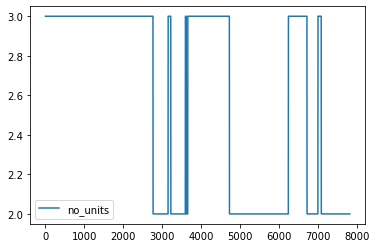

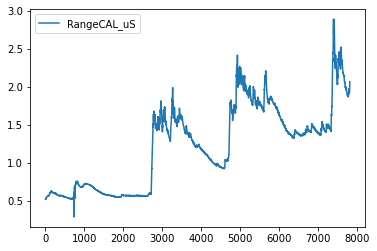

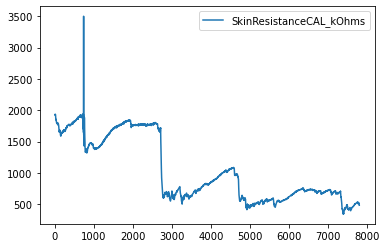

In [2]:
test612_1 = create_df_from_sheet("612_1")
plot_df(test612_1)

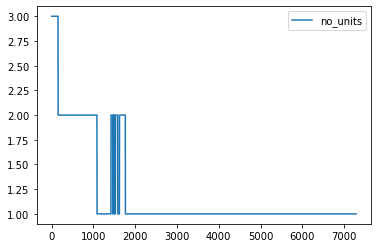

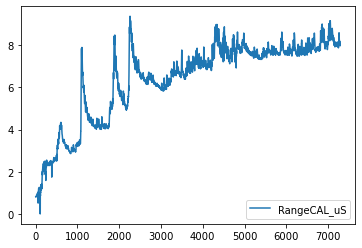

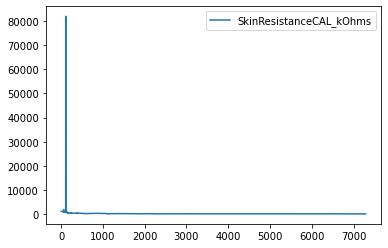

In [3]:
test612_2 = create_df_from_sheet("612_2")
plot_df(test612_2)

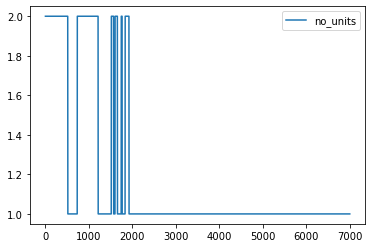

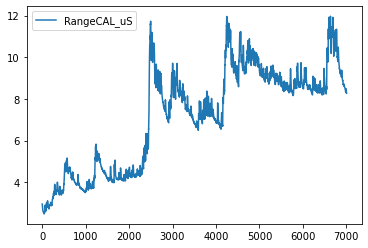

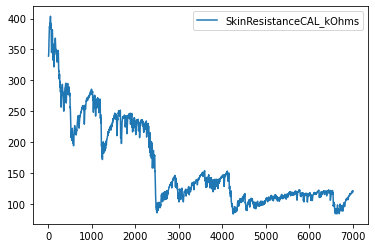

In [4]:
test612_3 = create_df_from_sheet("612_3")
plot_df(test612_3)

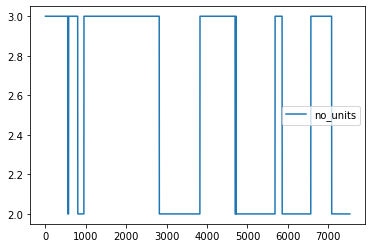

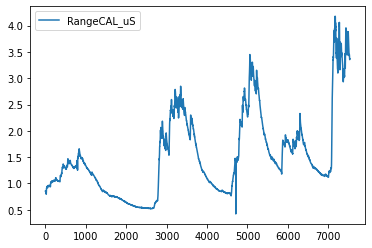

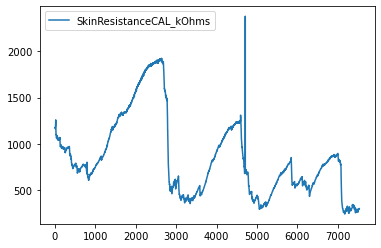

In [5]:
test612_4 = create_df_from_sheet("612_4")
plot_df(test612_4)

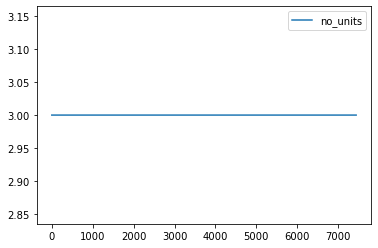

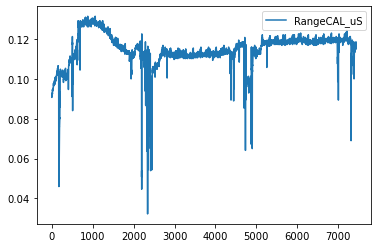

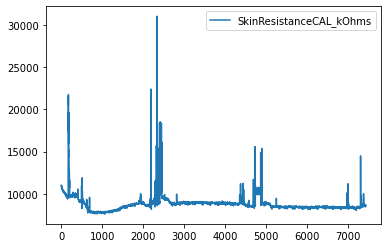

In [6]:
test612_5 = create_df_from_sheet("612_5")
plot_df(test612_5)

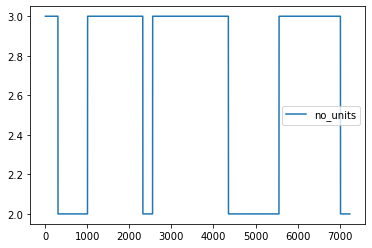

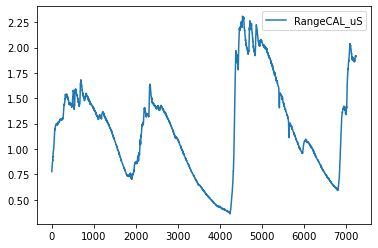

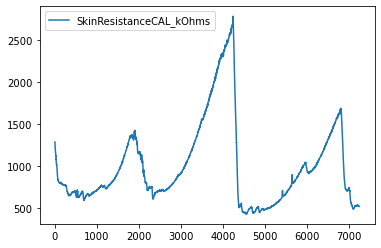

In [7]:
test612_6 = create_df_from_sheet("612_6")
plot_df(test612_6)

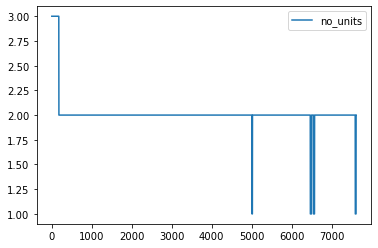

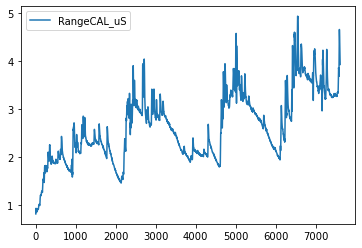

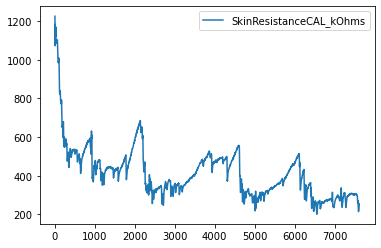

In [8]:
test612_7 = create_df_from_sheet("612_7")
plot_df(test612_7)

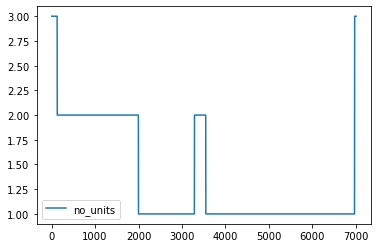

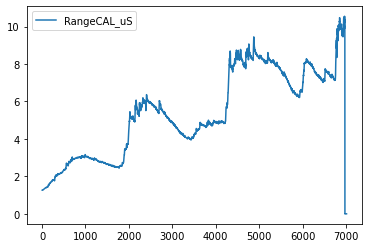

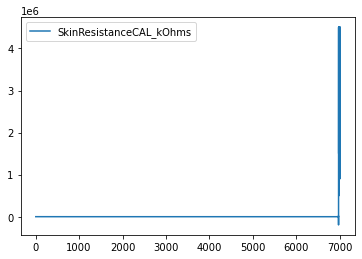

In [9]:
test712_1 = create_df_from_sheet("712_1")
plot_df(test712_1)

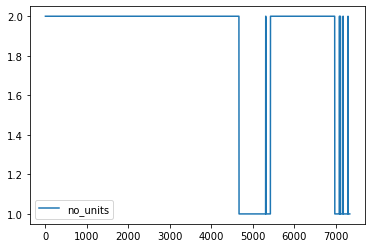

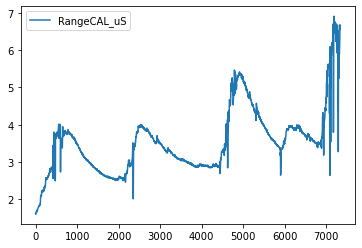

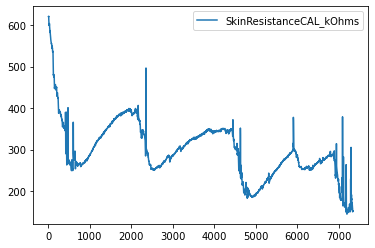

In [10]:
test712_2 = create_df_from_sheet("712_2")
plot_df(test712_2)

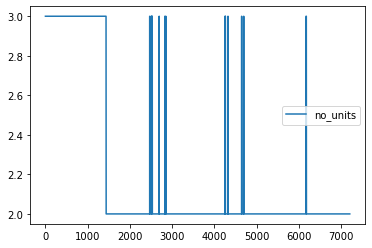

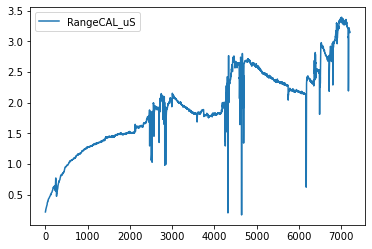

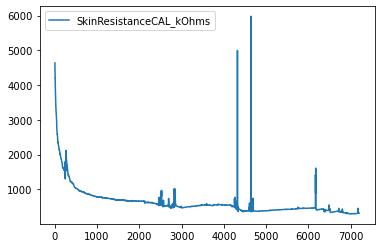

In [11]:
test712_3 = create_df_from_sheet("712_3")
plot_df(test712_3)

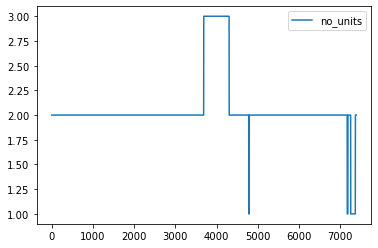

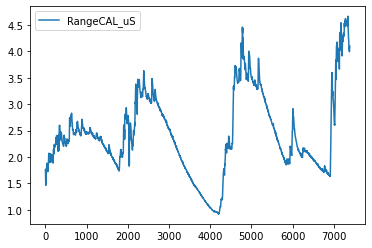

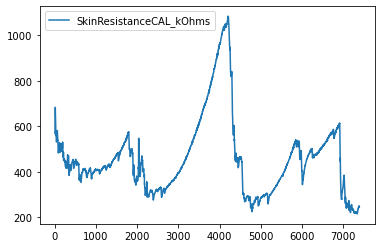

In [12]:
test712_4 = create_df_from_sheet("712_4")
plot_df(test712_4)

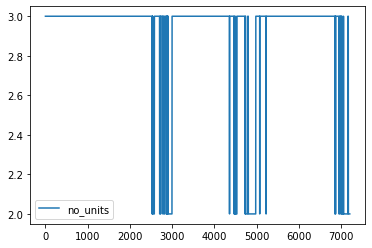

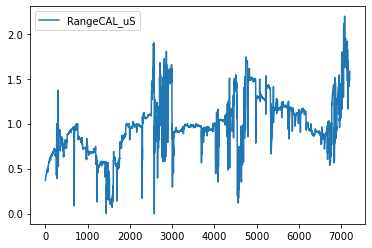

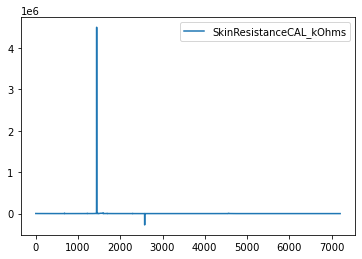

In [13]:
test712_5 = create_df_from_sheet("712_5")
plot_df(test712_5)

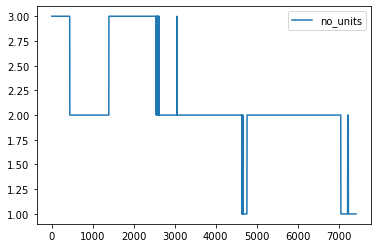

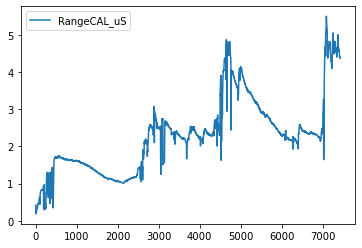

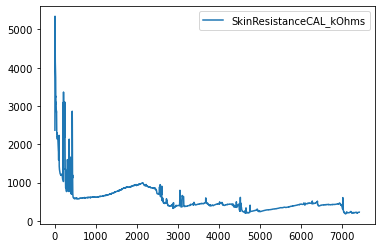

In [14]:
test712_6 = create_df_from_sheet("712_6")
plot_df(test712_6)

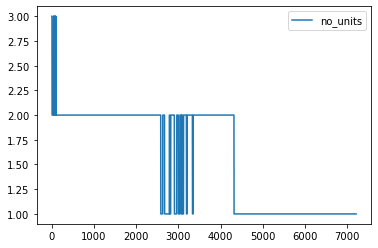

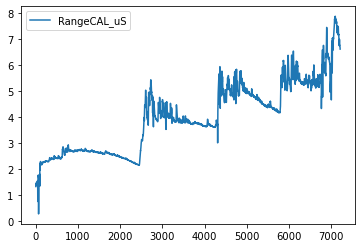

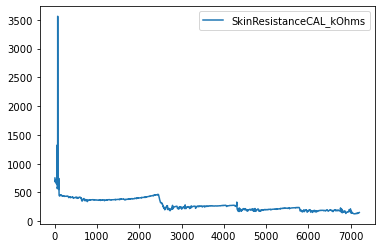

In [15]:
test712_7 = create_df_from_sheet("712_7")
plot_df(test712_7)

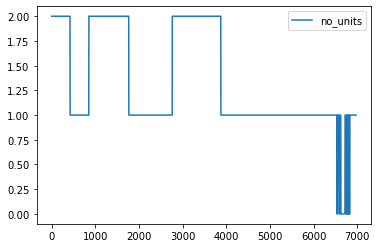

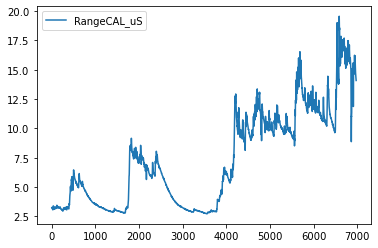

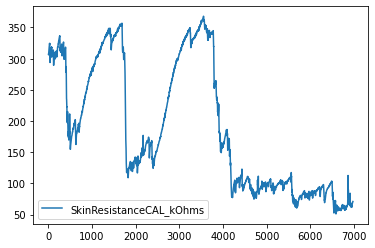

In [16]:
test712_8 = create_df_from_sheet("712_8")
plot_df(test712_8)

In [17]:
dfTemp = test712_6
df1_1 = dfTemp.iloc[:, [0, 1]]
df1_2 = dfTemp.iloc[:, [0, 2]]
df1_3 = dfTemp.iloc[:, [0, 3]]
df1_2

,timestamp,RangeCAL_uS
2,2021/12/07 16:33:05.584,0.422466
3,2021/12/07 16:33:05.834,0.284826
4,2021/12/07 16:33:06.084,0.188478
5,2021/12/07 16:33:06.334,0.187146
6,2021/12/07 16:33:06.584,0.18759
...,...,...
7424,2021/12/07 17:04:01.776,4.377736
7425,2021/12/07 17:04:02.026,4.377736
7426,2021/12/07 17:04:02.276,4.372631
7427,2021/12/07 17:04:02.526,4.377736


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7427 entries, 2 to 7428
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    7427 non-null   object
 1   RangeCAL_uS  7427 non-null   object
dtypes: object(2)
memory usage: 116.2+ KB


C:\Users\daanb\AppData\Local\Temp\ipykernel_16116\613670273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_2['RollingMean'] = df1_2['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)


,timestamp,RangeCAL_uS,RollingMean,RollingMedian,deltaMean,deltaMedian
2,2021/12/07 16:33:05.584,0.422466,NaN,NaN,NaN,NaN
3,2021/12/07 16:33:05.834,0.284826,NaN,NaN,NaN,NaN
4,2021/12/07 16:33:06.084,0.188478,NaN,NaN,NaN,NaN
5,2021/12/07 16:33:06.334,0.187146,NaN,NaN,NaN,NaN
6,2021/12/07 16:33:06.584,0.18759,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
7424,2021/12/07 17:04:01.776,4.377736,4.520172,4.543656,-0.205741,-0.114868
7425,2021/12/07 17:04:02.026,4.377736,4.512514,4.528340,-0.206890,-0.125078
7426,2021/12/07 17:04:02.276,4.372631,4.505239,4.513025,-0.206251,-0.137841
7427,2021/12/07 17:04:02.526,4.377736,4.498347,4.502814,-0.204465,-0.137841


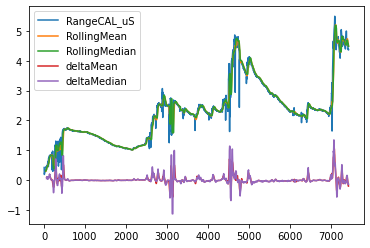

In [18]:

df1_2.info()
df1_2['RollingMean'] = df1_2['RangeCAL_uS'].rolling(40).mean() # rolling average of 10 seconds (4 units = 1 second)

df1_2['RollingMedian'] = df1_2['RangeCAL_uS'].rolling(40).median() # rolling median of 10 seconds
df1_2['deltaMean'] = df1_2.RollingMean.diff(periods =20)
df1_2['deltaMedian'] = df1_2.RollingMedian.diff(periods =20)
df1_2.plot()
df1_2

In [81]:
anomaly_detection_df = df1_2[['timestamp', 'RollingMean']].copy().dropna()
anomaly_detection_df = anomaly_detection_df.reset_index()
# anomaly_detection_df['time_index'] = anomaly_detection_df.index
anomaly_detection_df

,index,timestamp,RollingMean,time_index
0,41,2021/12/07 16:33:15.334,0.290077,0
1,42,2021/12/07 16:33:15.584,0.288301,1
2,43,2021/12/07 16:33:15.834,0.290720,2
3,44,2021/12/07 16:33:16.084,0.296570,3
4,45,2021/12/07 16:33:16.334,0.302631,4
...,...,...,...,...
7383,7424,2021/12/07 17:04:01.776,4.520172,7383
7384,7425,2021/12/07 17:04:02.026,4.512514,7384
7385,7426,2021/12/07 17:04:02.276,4.505239,7385
7386,7427,2021/12/07 17:04:02.526,4.498347,7386


In [88]:
from sklearn.ensemble import IsolationForest

IF = IsolationForest(random_state=0, contamination=0.005, n_estimators=200, max_samples=0.7)
model_data = anomaly_detection_df[['RollingMean']]
IF.fit(model_data)

anomaly_detection_df['scores']=IF.decision_function(model_data)
anomaly_detection_df['anomaly']=IF.predict(model_data)

anomaly=anomaly_detection_df.loc[anomaly_detection_df['anomaly']==-1]
anomaly_index=list(anomaly.index)

print(anomaly)
print(anomaly_index)

C:\Users\daanb\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


      index                timestamp  RollingMean  time_index    scores  \
0        41  2021/12/07 16:33:15.334     0.290077           0 -0.042146   
1        42  2021/12/07 16:33:15.584     0.288301           1 -0.056548   
2        43  2021/12/07 16:33:15.834     0.290720           2 -0.041238   
3        44  2021/12/07 16:33:16.084     0.296570           3 -0.041875   
4        45  2021/12/07 16:33:16.334     0.302631           4 -0.037209   
5        46  2021/12/07 16:33:16.584     0.308802           5 -0.030947   
6        47  2021/12/07 16:33:16.834     0.314807           6 -0.023841   
7        48  2021/12/07 16:33:17.084     0.320391           7 -0.021067   
8        49  2021/12/07 16:33:17.334     0.325608           8 -0.016822   
9        50  2021/12/07 16:33:17.583     0.330780           9 -0.012487   
10       51  2021/12/07 16:33:17.833     0.335897          10 -0.006597   
7054   7095  2021/12/07 17:02:39.529     4.959094        7054 -0.001237   
7056   7097  2021/12/07 1